# IMPORT PACKAGES

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Standard Libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

from fastdtw import fastdtw
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm
from collections import Counter

In [4]:
# Custom Libraries 
import python_libraries.fitting_func as fitfunc
import python_libraries.peak_finder as peakfunc
import python_libraries.plotting_func as plotfunc
import python_libraries.utilities as utils
import python_libraries.outlier_detection as outfunc

In [5]:
# Machine Learning Libraries
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

from scipy.spatial.distance import euclidean

from numpy.random import seed

seed(10)

# FUNCTIONS

In [6]:
# NN model using a combination of Convolution and Recurrent Neurons 

def create_model():

    comb = Sequential()

    comb.add(Conv1D(filters = 6, kernel_size = 5, activation ='relu', input_shape = (40, 1)))
    # comb.add(MaxPooling1D(pool_size=2))
    comb.add(Conv1D(filters = 3, kernel_size = 5, activation ='relu'))
    comb.add(Dropout(0.5))
    comb.add(Flatten())

    comb.add(Dense(5, activation = 'softmax'))

    comb.summary()

    return comb

def create_model_2():

    rnn = Sequential()

    rnn.add(LSTM(6, input_shape = (40, 1), activation='relu'))
    rnn.add(Dropout(0.5))

    rnn.add(Dense(5, activation = 'softmax'))

    rnn.summary()
    
    return rnn

def train_ACA_model(X_AC_train, y_train, NN):

    if NN:
        clf_AC = create_model()

        clf_AC.compile(optimizer='adam', 
                        loss='sparse_categorical_crossentropy', 
                        metrics=['accuracy'])

        X_ = X_AC_train.copy()
        y_ = y_train.copy()
                
        h = clf_AC.fit(X_, y_, shuffle=True, batch_size=20, epochs=400,
                    verbose=1, validation_split = 0.25, callbacks= EarlyStopping(monitor='val_loss', patience=400))

        clf_AC_proba = clf_AC.predict(X_AC_train)

    else:
        h = []
        clf_AC = KNeighborsClassifier(n_neighbors=5)
        clf_AC.fit(X_AC_train, y_train)

        clf_AC_proba = clf_AC.predict_proba(X_AC_train)

    return (clf_AC, clf_AC_proba, h)


def train_MCA_model(X_MC_train, y_train, NN):

    clf_MC = LogisticRegression(max_iter=1000) # Create Model

    clf_MC.fit(X_MC_train, y_train) # Train Model

    clf_MC_proba = clf_MC.predict_proba(X_MC_train) # Output Probabilities

    return (clf_MC, clf_MC_proba)
  
  
def train_AMCA_model(X_AC_MC_train, y_train):
    
    clf = LogisticRegression(max_iter=1000, fit_intercept=False)
    
    clf.fit(X_AC_MC_train, y_train)

    clf_proba = clf.predict_proba(X_AC_MC_train)
    
    return (clf, clf_proba)

# PREPROCESS


In [8]:
df_dAC_raw = pd.read_csv('dataframe_saved/00_df_raw_AC_LAMP.csv', header=0, index_col=0, low_memory=False)
df_dMC_raw = pd.read_csv('dataframe_saved/00_df_raw_MC_LAMP.csv', header=0, index_col=0, low_memory=False)

df_dAC_raw.reset_index(drop=True, inplace=True)
df_dMC_raw.reset_index(drop=True, inplace=True)
NMETA=6

In [9]:
# background removal from amplification curves
remove_bs = lambda x: fitfunc.remove_background(x, order=0, n_ct_fit=5, n_ct_skip=3)
df_dAC_raw_bs = utils.apply_processing(df_dAC_raw, func=remove_bs, N=NMETA)

ampl_thresh = 0.2 # fluorescence threshold
ct_thresh = 35 # ct threshold

df_dAC_nometa = df_dAC_raw_bs.iloc[:, NMETA:].transpose()
idx_dAC_pos = fitfunc.is_positive_iloc(df_dAC_nometa, ampl_thresh=ampl_thresh, ct_thresh=ct_thresh)
df_dAC_pos = df_dAC_raw_bs.loc[idx_dAC_pos]

# MC down-selection of positive samples based on AC thresholds
df_dMC_pos = df_dMC_raw.loc[idx_dAC_pos]

In [8]:
melt_height_thresh = 0.03

# Melting Peaks finder for positives
df_dMC_peak = df_dMC_pos.iloc[:, :NMETA].copy()

df_dMC_nometa = df_dMC_pos.iloc[:, NMETA:].transpose()
df_dMC_nometa.index = df_dMC_nometa.index.map(float)

df_dMC_peak['MeltPeaks'] = peakfunc.find_peaks(df_dMC_nometa, height=melt_height_thresh)

# Creating a Master_DF with MC peaks and AC values
df_master = df_dMC_peak.join(df_dAC_pos.iloc[:, NMETA:])

# Data down-selection based on MC Peaks (if there is only "ONE" peak the sample is considered positive)
idx_pos_MC_peak = df_master.MeltPeaks.map(len)==1  # ONLY ONE PEAK
df_master = df_master[idx_pos_MC_peak]
df_master['MeltPeaks'] = df_master['MeltPeaks'].apply(lambda x: x[0])

# HERE we downselect from the df_ampl the curve with a single value for ["MeltPeaks"]
df_AC_bs_filt = df_dAC_pos[idx_pos_MC_peak] # AC only filtered
df_MC_filt = df_dMC_pos[idx_pos_MC_peak] # MC only filtered
df_MC_peak_filt = df_dMC_peak[idx_pos_MC_peak] # MC peak filtered

  0%|          | 0/7811 [00:00<?, ?it/s]

In [ ]:
df_master.to_csv('dataframe_saved/01_df_master.csv')
df_MC_filt.to_csv('dataframe_saved/01_df_MC_filt.csv')

# LOAD DATA

In [10]:
df_master = pd.read_csv('dataframe_saved/01_df_master.csv', header=0, index_col=0, low_memory=False)
df_MC_filt = pd.read_csv('dataframe_saved/01_df_MC_filt.csv', header=0, index_col=0, low_memory=False)

# PLOT 

  0%|          | 0/4 [00:00<?, ?it/s]

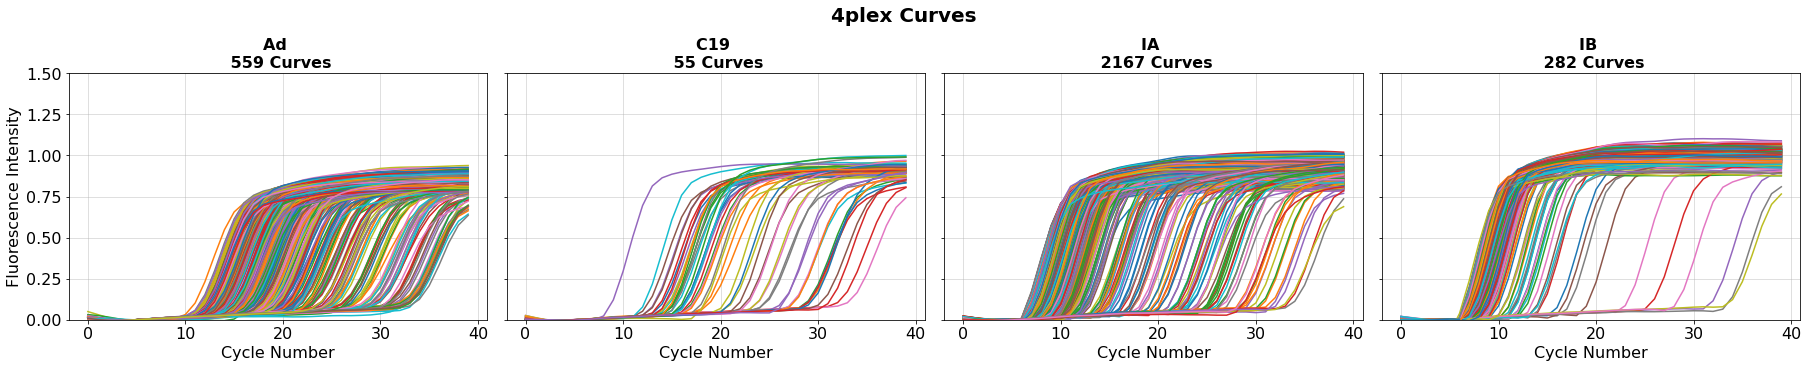

In [35]:
df_4plex = df_master[df_master.PrimerMix == '4plex1']
x = np.array(range(0, 40))
fig, ax = plt.subplots(1,4, figsize=(25, 5), constrained_layout=True)

fig.suptitle('4plex Curves', fontsize=20, weight="bold")

for i, (target, df) in enumerate(tqdm(df_4plex.groupby('Target'))): 

    ax[i].set_title(f"{target} \n {df.shape[0]} Curves", fontsize=16, weight='bold')
    ax[i].plot(x, df.iloc[:, NMETA+1:].T)
    ax[i].set_xlabel('Cycle Number', fontsize=16)
    ax[0].set_ylabel('Fluorescence Intensity', fontsize=16)
    ax[i].grid(alpha = 0.5)
    ax[i].set_ylim((0, 1.5))

    ax[i].tick_params(axis='x', labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16) 

    if i>0:
        ax[i].set_yticklabels([])

plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

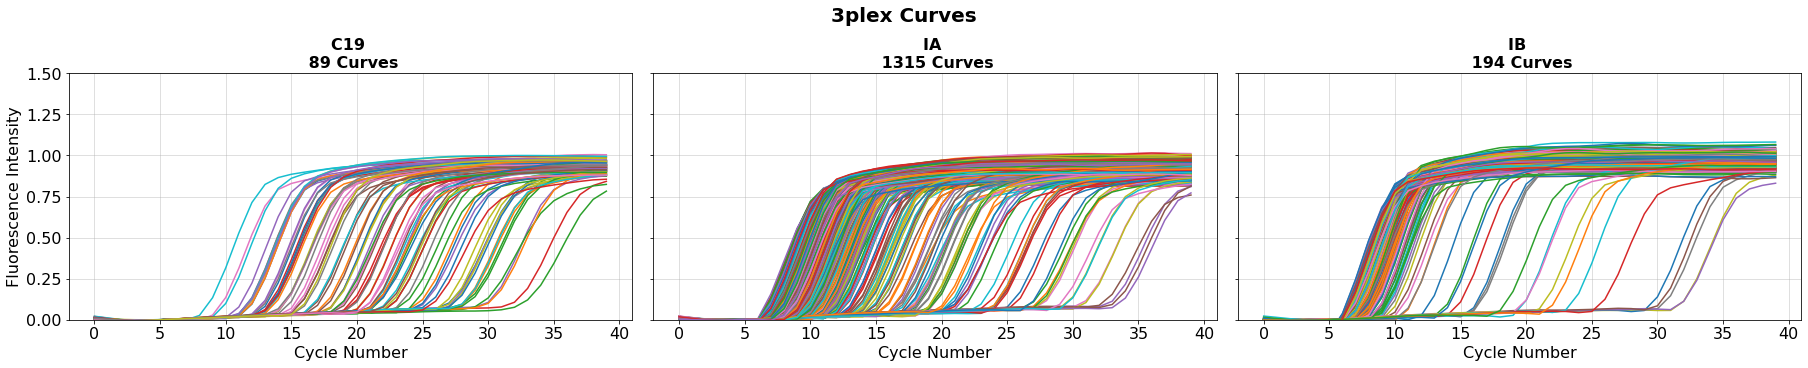

In [36]:
df_3plex = df_master[df_master.PrimerMix == '3plex1']
x = np.array(range(0, 40))
fig, ax = plt.subplots(1,3, figsize=(25, 5), constrained_layout=True)

fig.suptitle('3plex Curves', fontsize=20, weight="bold")

for i, (target, df) in enumerate(tqdm(df_3plex.groupby('Target'))): 

    ax[i].set_title(f"{target} \n {df.shape[0]} Curves", fontsize=16, weight='bold')
    ax[i].plot(x, df.iloc[:, NMETA+1:].T)
    ax[i].set_xlabel('Cycle Number', fontsize=16)
    ax[0].set_ylabel('Fluorescence Intensity', fontsize=16)
    ax[i].grid(alpha = 0.5)
    ax[i].set_ylim((0, 1.5))

    ax[i].tick_params(axis='x', labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16) 

    if i>0:
        ax[i].set_yticklabels([])

plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

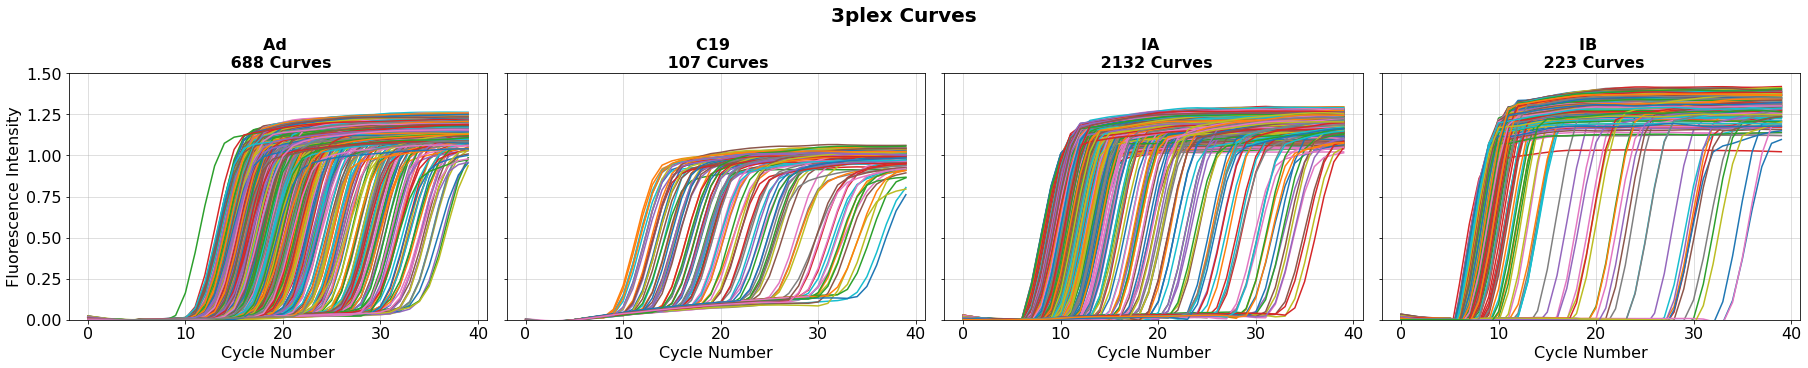

In [37]:
df_single = df_master[~df_master['PrimerMix'].isin(['3plex1', '4plex1'])]
x = np.array(range(0, 40))
fig, ax = plt.subplots(1,4, figsize=(25, 5), constrained_layout=True)

fig.suptitle('3plex Curves', fontsize=20, weight="bold")

for i, (target, df) in enumerate(tqdm(df_single.groupby('Target'))): 

    ax[i].set_title(f"{target} \n {df.shape[0]} Curves", fontsize=16, weight='bold')
    ax[i].plot(x, df.iloc[:, NMETA+1:].T)
    ax[i].set_xlabel('Cycle Number', fontsize=16)
    ax[0].set_ylabel('Fluorescence Intensity', fontsize=16)
    ax[i].grid(alpha = 0.5)
    ax[i].set_ylim((0, 1.5))

    ax[i].tick_params(axis='x', labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16) 

    if i>0:
        ax[i].set_yticklabels([])

plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

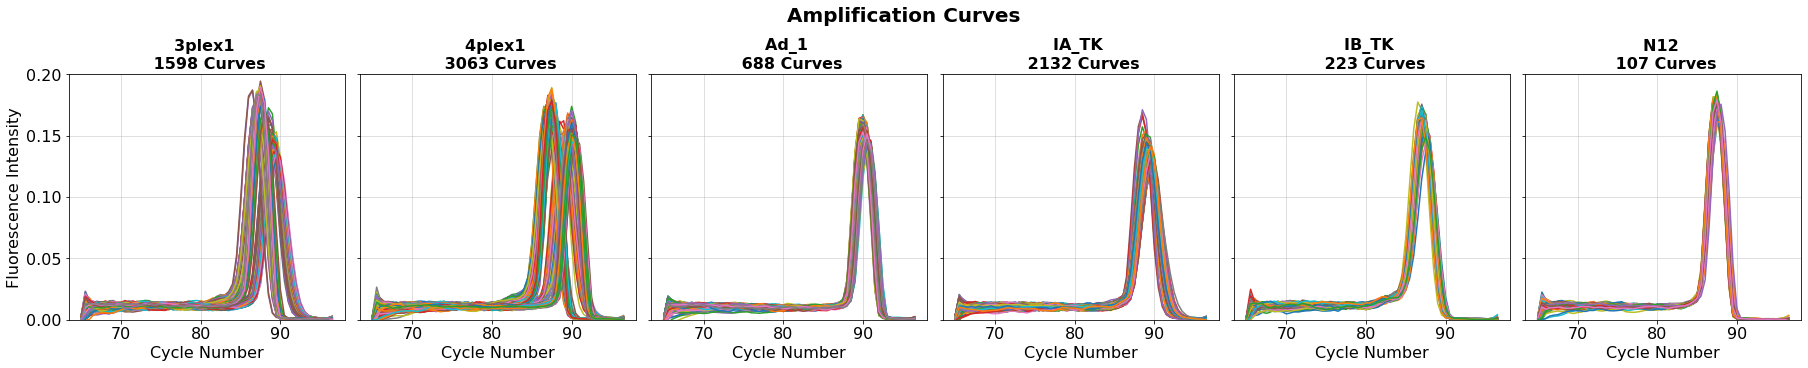

In [12]:
fig, ax = plt.subplots(1,6, figsize=(25, 5), constrained_layout=True)

fig.suptitle('Amplification Curves', fontsize=20, weight="bold")

for i, (target, df) in enumerate(tqdm(df_MC_filt.groupby('PrimerMix'))): 

    ax[i].set_title(f"{target} \n {df.shape[0]} Curves", fontsize=16, weight='bold')

    x = df.iloc[:,NMETA:].columns.map(float)
    ax[i].plot(x, df.iloc[:, NMETA:].T)
    ax[i].set_xlabel('Cycle Number', fontsize=16)
    ax[0].set_ylabel('Fluorescence Intensity', fontsize=16)
    ax[i].grid(alpha = 0.5)
    ax[i].set_ylim((0, 0.2))    

    ax[i].tick_params(axis='x', labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16) 

    if i>0:
        ax[i].set_yticklabels([])

plt.show()

# C-Param


In [14]:
df_param = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/FYP/LAMP/dataframe_saved/00_params.csv', header=0, index_col=0, low_memory=False)

In [17]:
df_param

,Channel,PrimerMix,Target,Assay,Conc,Exp_id,a,b,c,d,e,MSE
0,panel02,4plex1,IA,IA_TK,10000000,20210702_01,0.900729,-0.011263,0.630668,2.209754,100.000000,0.000143
1,panel02,4plex1,IA,IA_TK,10000000,20210702_01,0.898442,0.000620,0.611214,3.145030,100.000000,0.000203
2,panel02,4plex1,IA,IA_TK,10000000,20210702_01,0.892220,-0.024204,0.640229,1.891844,100.000000,0.000151
3,panel02,4plex1,IA,IA_TK,10000000,20210702_01,0.891321,-0.017418,0.617046,1.880616,100.000000,0.000202
4,panel02,4plex1,IA,IA_TK,10000000,20210702_01,0.899072,-0.025472,0.620911,1.674662,100.000000,0.000203
...,...,...,...,...,...,...,...,...,...,...,...,...
7806,panel48,Ad_1,Ad,Ad_1,1000000,20210702_01,1.070666,0.002348,0.727052,15.742222,3.044146,0.000108
7807,panel48,Ad_1,Ad,Ad_1,1000000,20210702_01,1.140669,0.004428,0.624251,15.579115,3.488093,0.000116
7808,panel48,Ad_1,Ad,Ad_1,1000000,20210702_01,1.063989,0.002917,0.649269,12.817706,10.404436,0.000177
7809,panel48,Ad_1,Ad,Ad_1,1000000,20210702_01,1.140897,0.001965,0.681336,16.681310,3.042398,0.000093


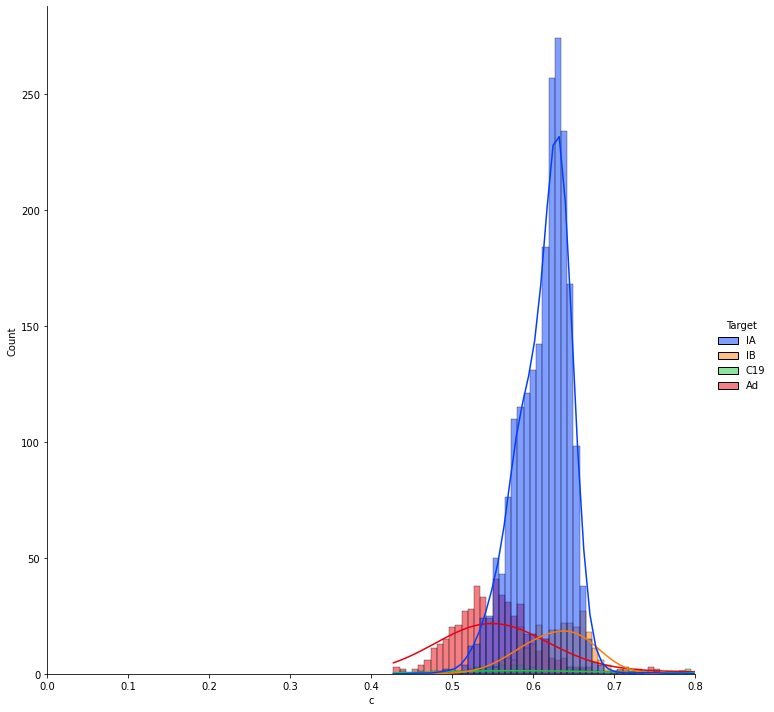

In [22]:
df_4plex_param = df_param[df_param.PrimerMix == '4plex1']

sns.displot(data=df_4plex_param, x='c', hue='Target', kde=True, fill=True, palette=sns.color_palette('bright')[:4], height=10, aspect=1)
plt.xlim(0.4, 0.9)
plt.show()

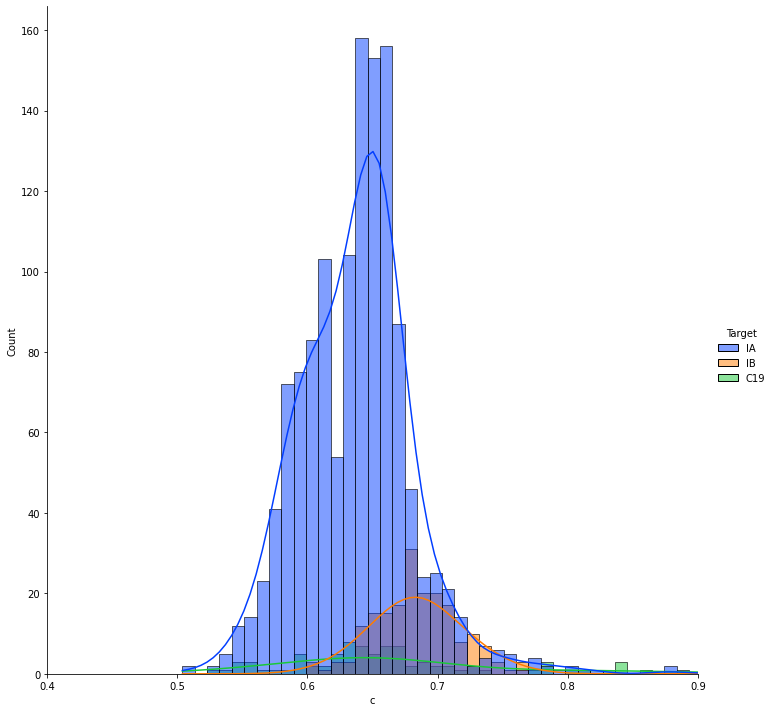

In [26]:
df_3plex_param = df_param[df_param.PrimerMix == '3plex1']

sns.displot(data=df_3plex_param, x='c', hue='Target', kde=True, fill=True, palette=sns.color_palette('bright')[:3], height=10, aspect=1)
plt.xlim(0.4, 0.9)
plt.show()

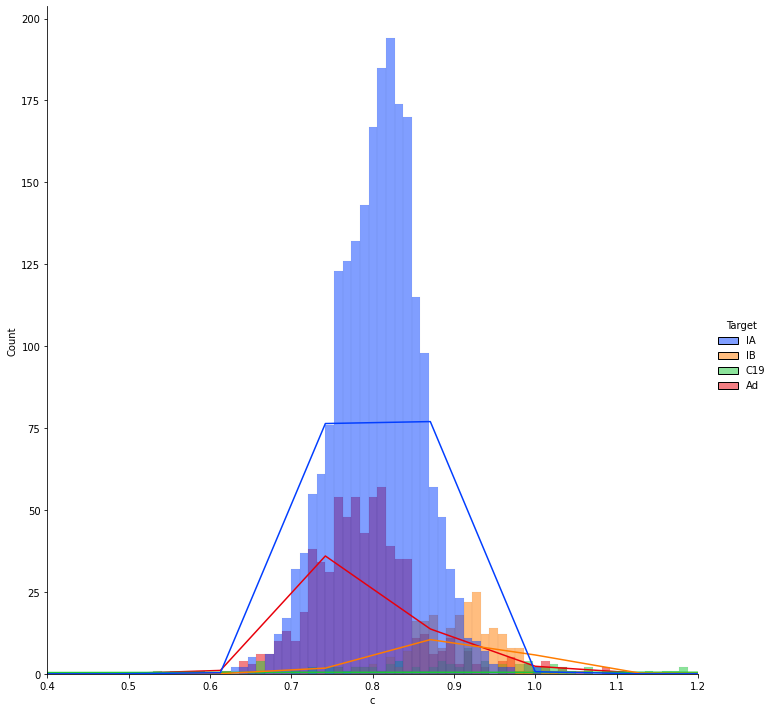

In [33]:
df_single_param = df_param[~df_param["PrimerMix"].isin(['3plex1','4plex1'])]

sns.displot(data=df_single_param, x='c', hue='Target', kde=True, fill=True, palette=sns.color_palette('bright')[:4], height=10, aspect=1)
plt.xlim(0.4, 1.2)
plt.show()

# ML

In [47]:
df_chosen = df_master[df_master.PrimerMix == '3plex1']

(1278, 40)
(1278, 1)
(1278,)
(320, 40)
(320, 1)
(320,)
(1278, 40)
(1278, 1)
(1278,)
(320, 40)
(320, 1)
(320,)
(1278, 40)
(1278, 1)
(1278,)
(320, 40)
(320, 1)
(320,)
(1279, 40)
(1279, 1)
(1279,)
(319, 40)
(319, 1)
(319,)
(1279, 40)
(1279, 1)
(1279,)
(319, 40)
(319, 1)
(319,)


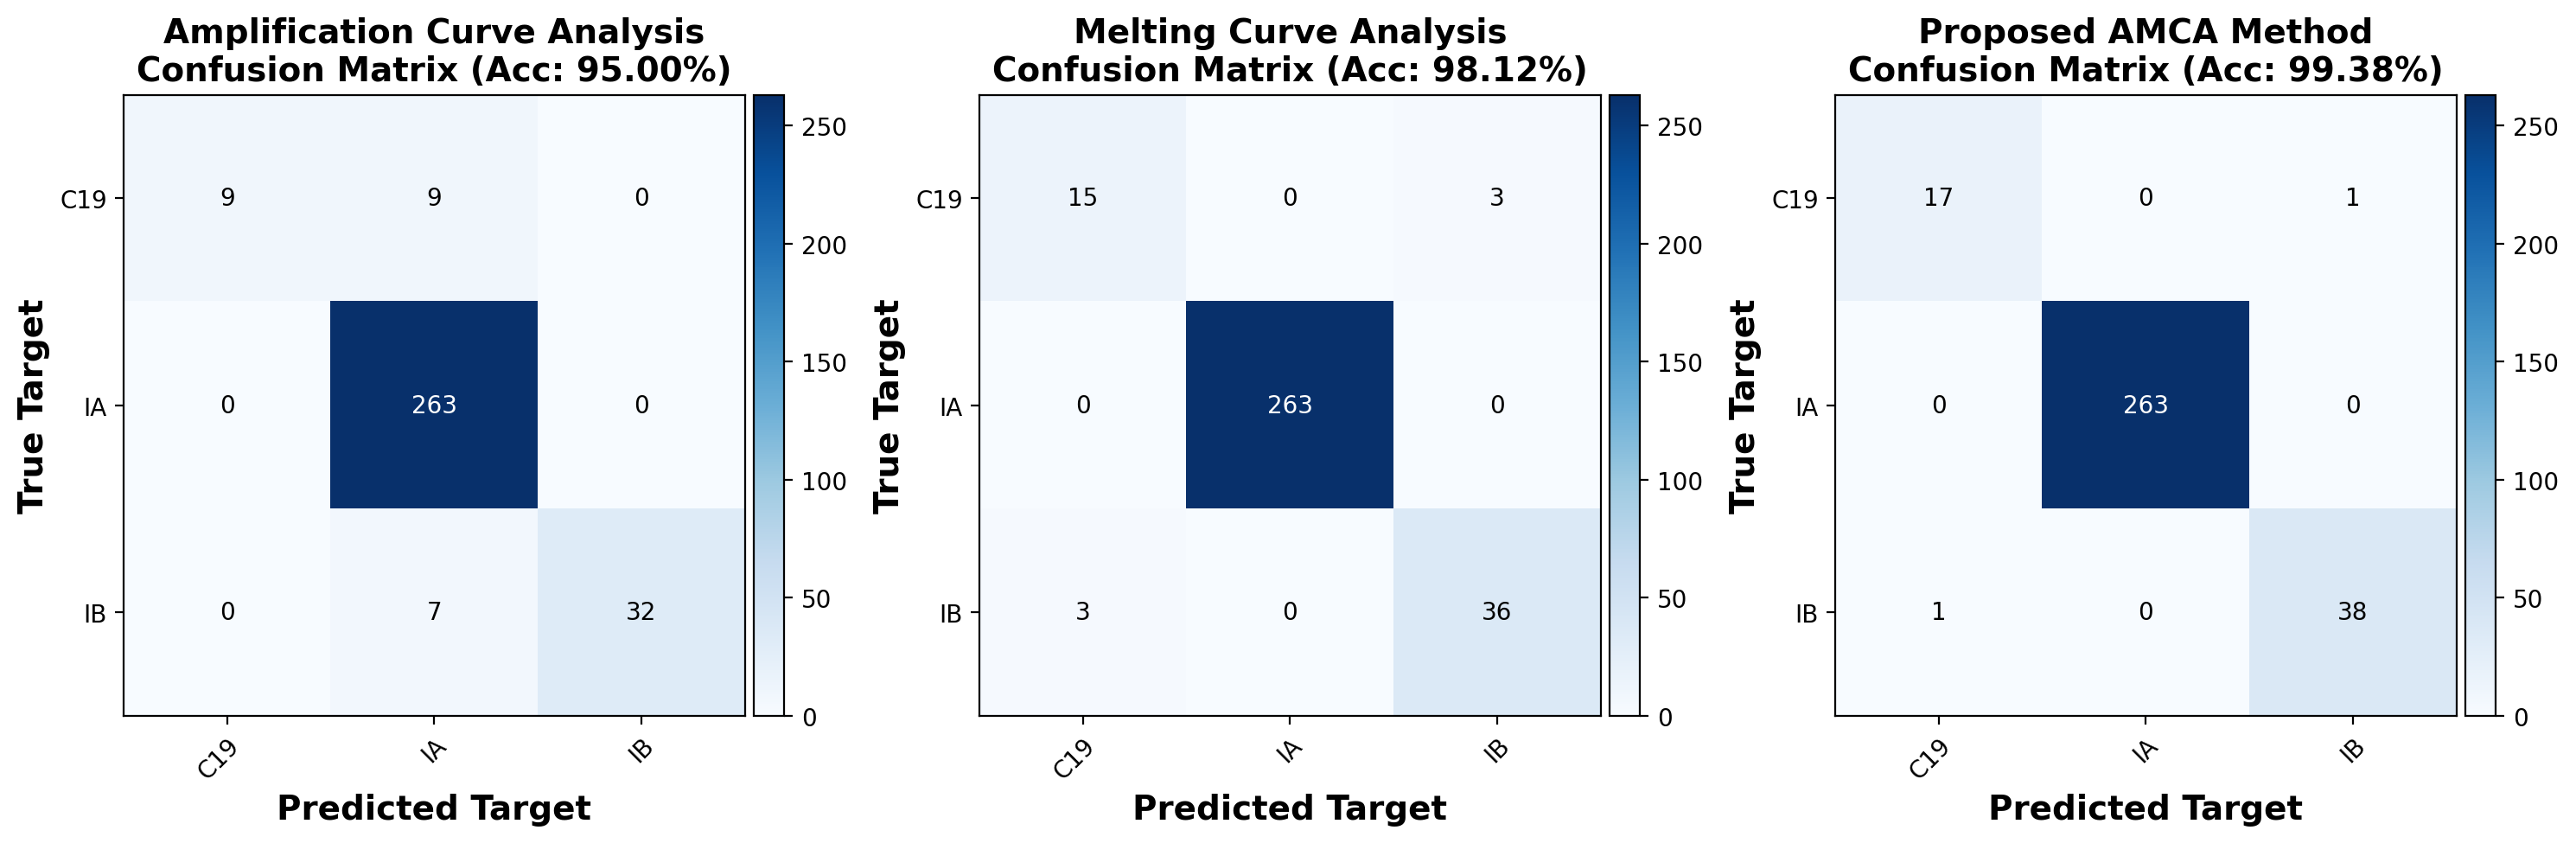

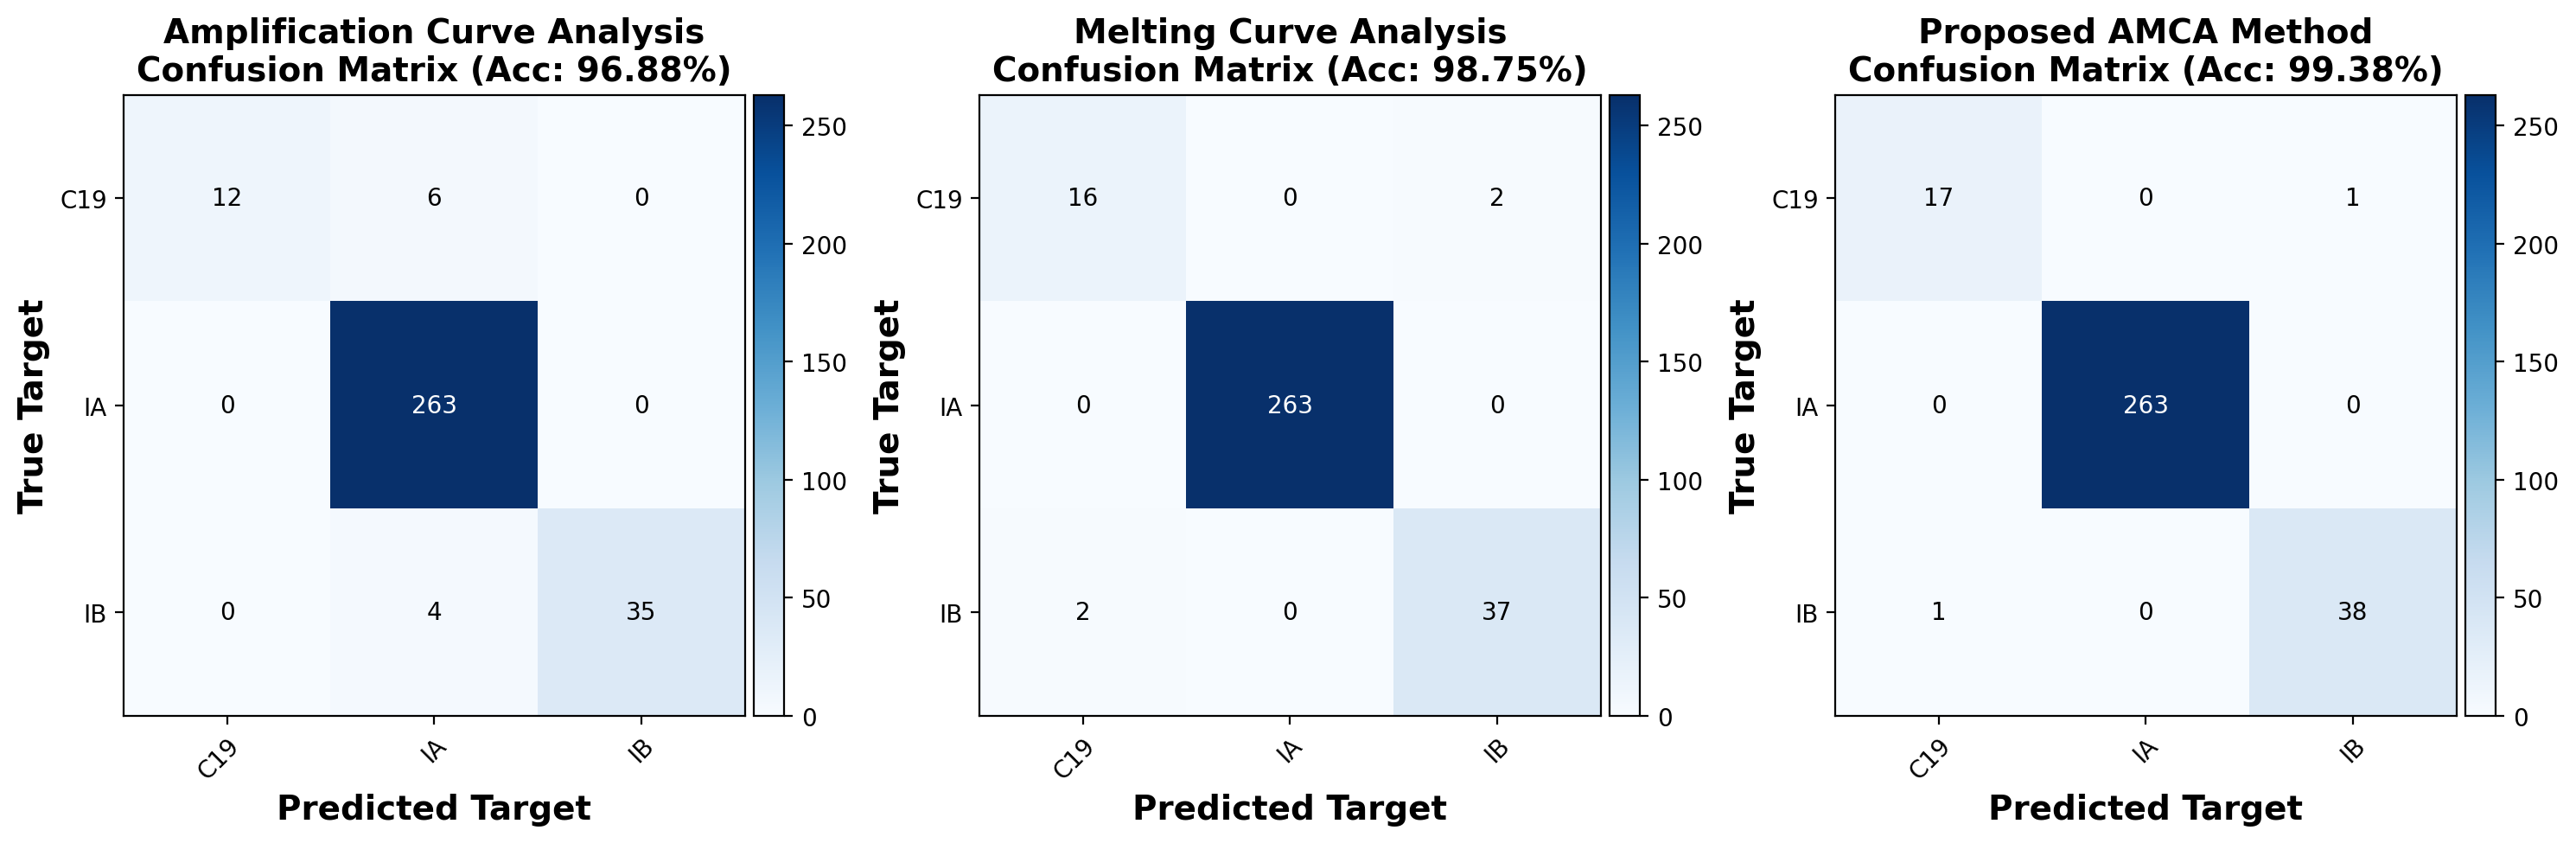

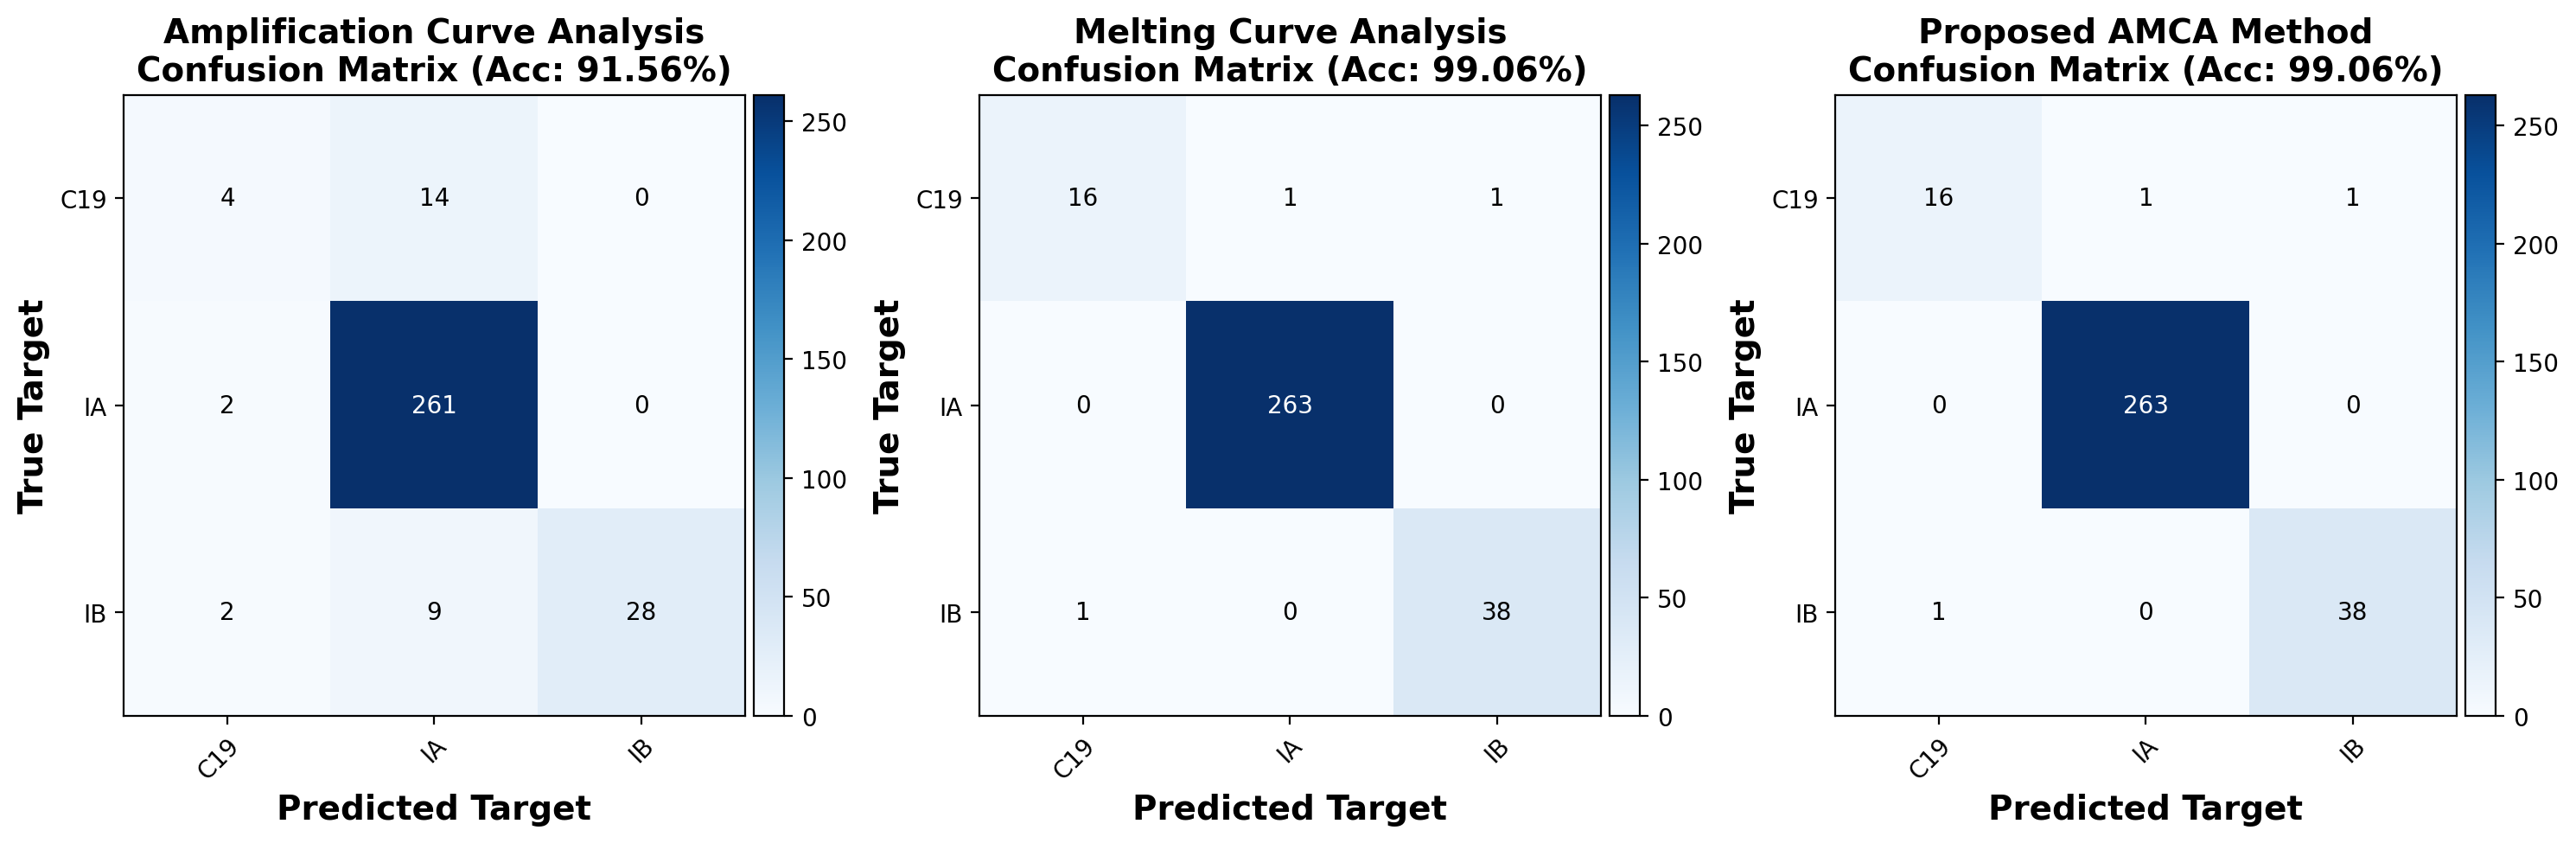

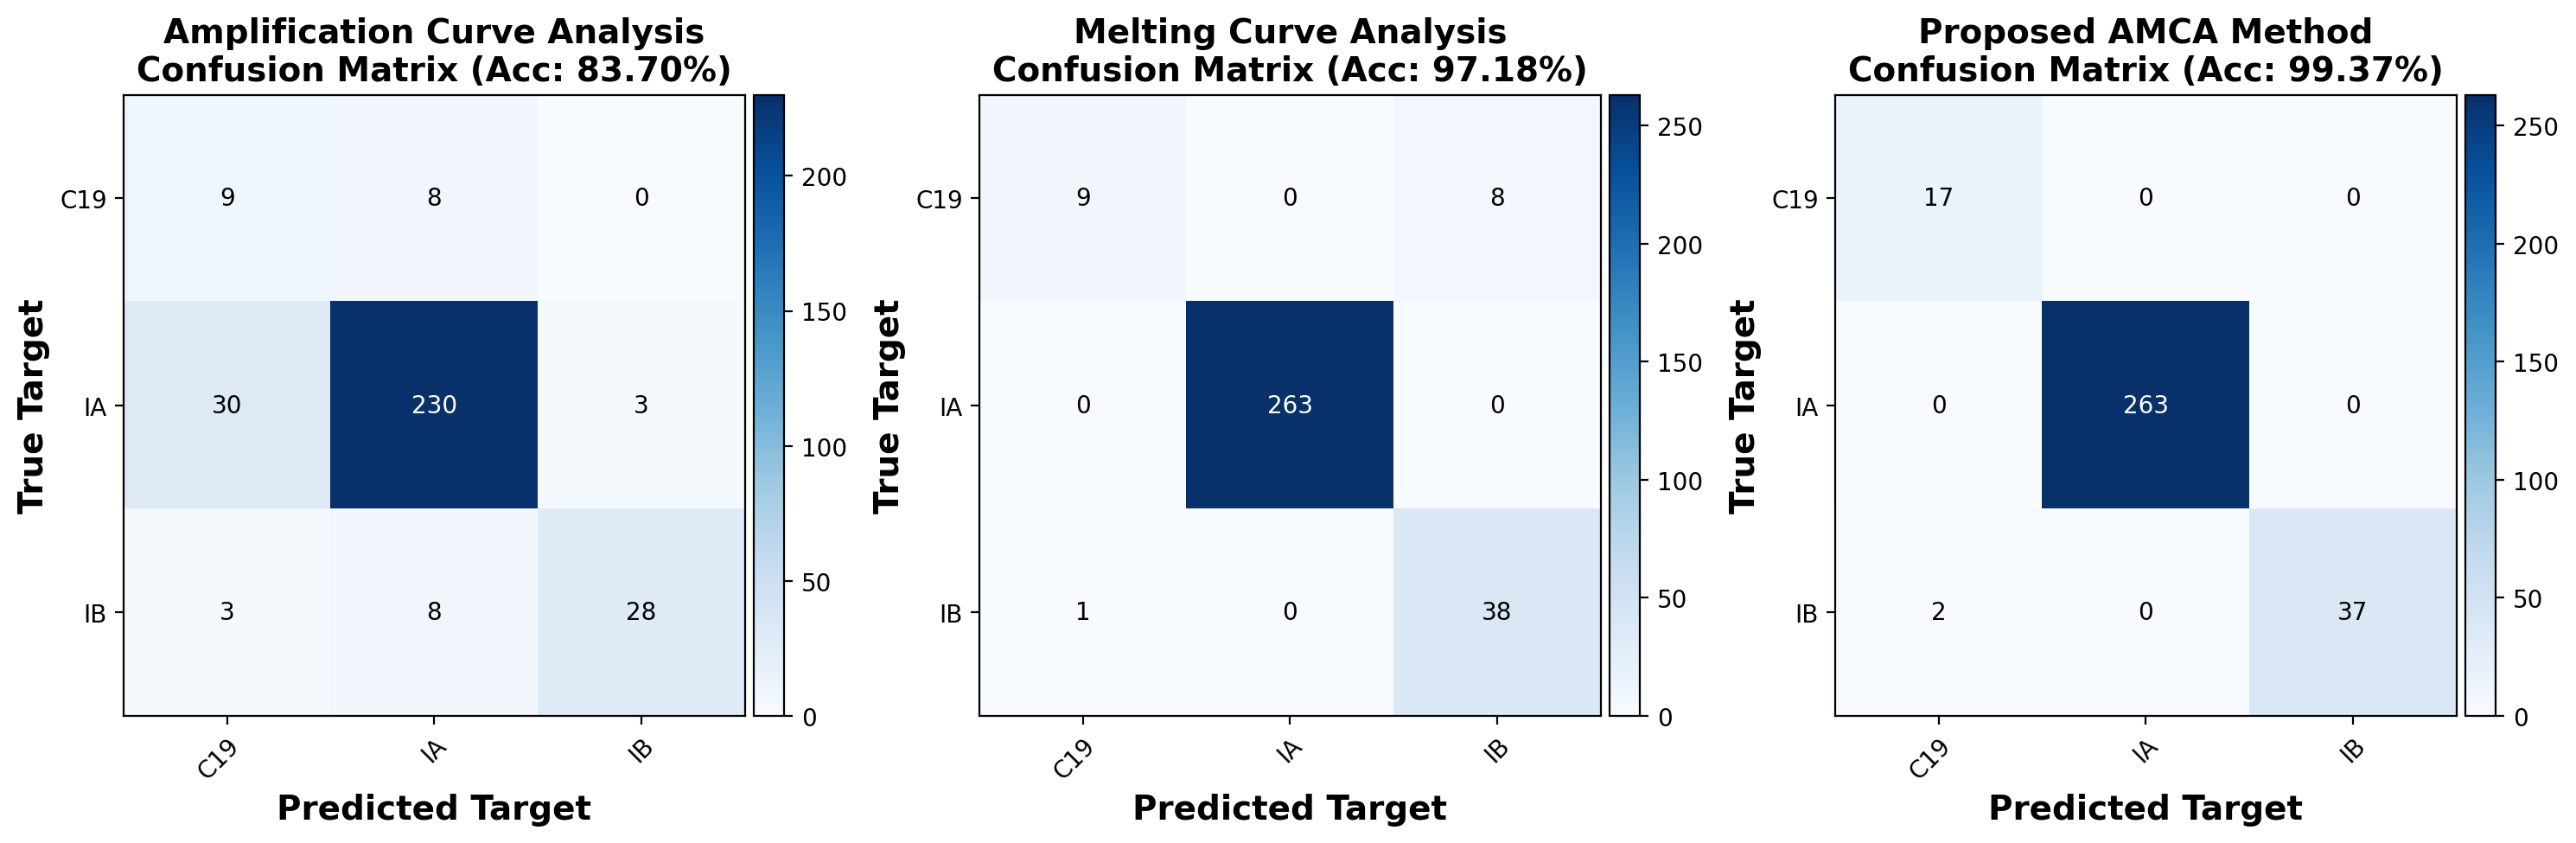

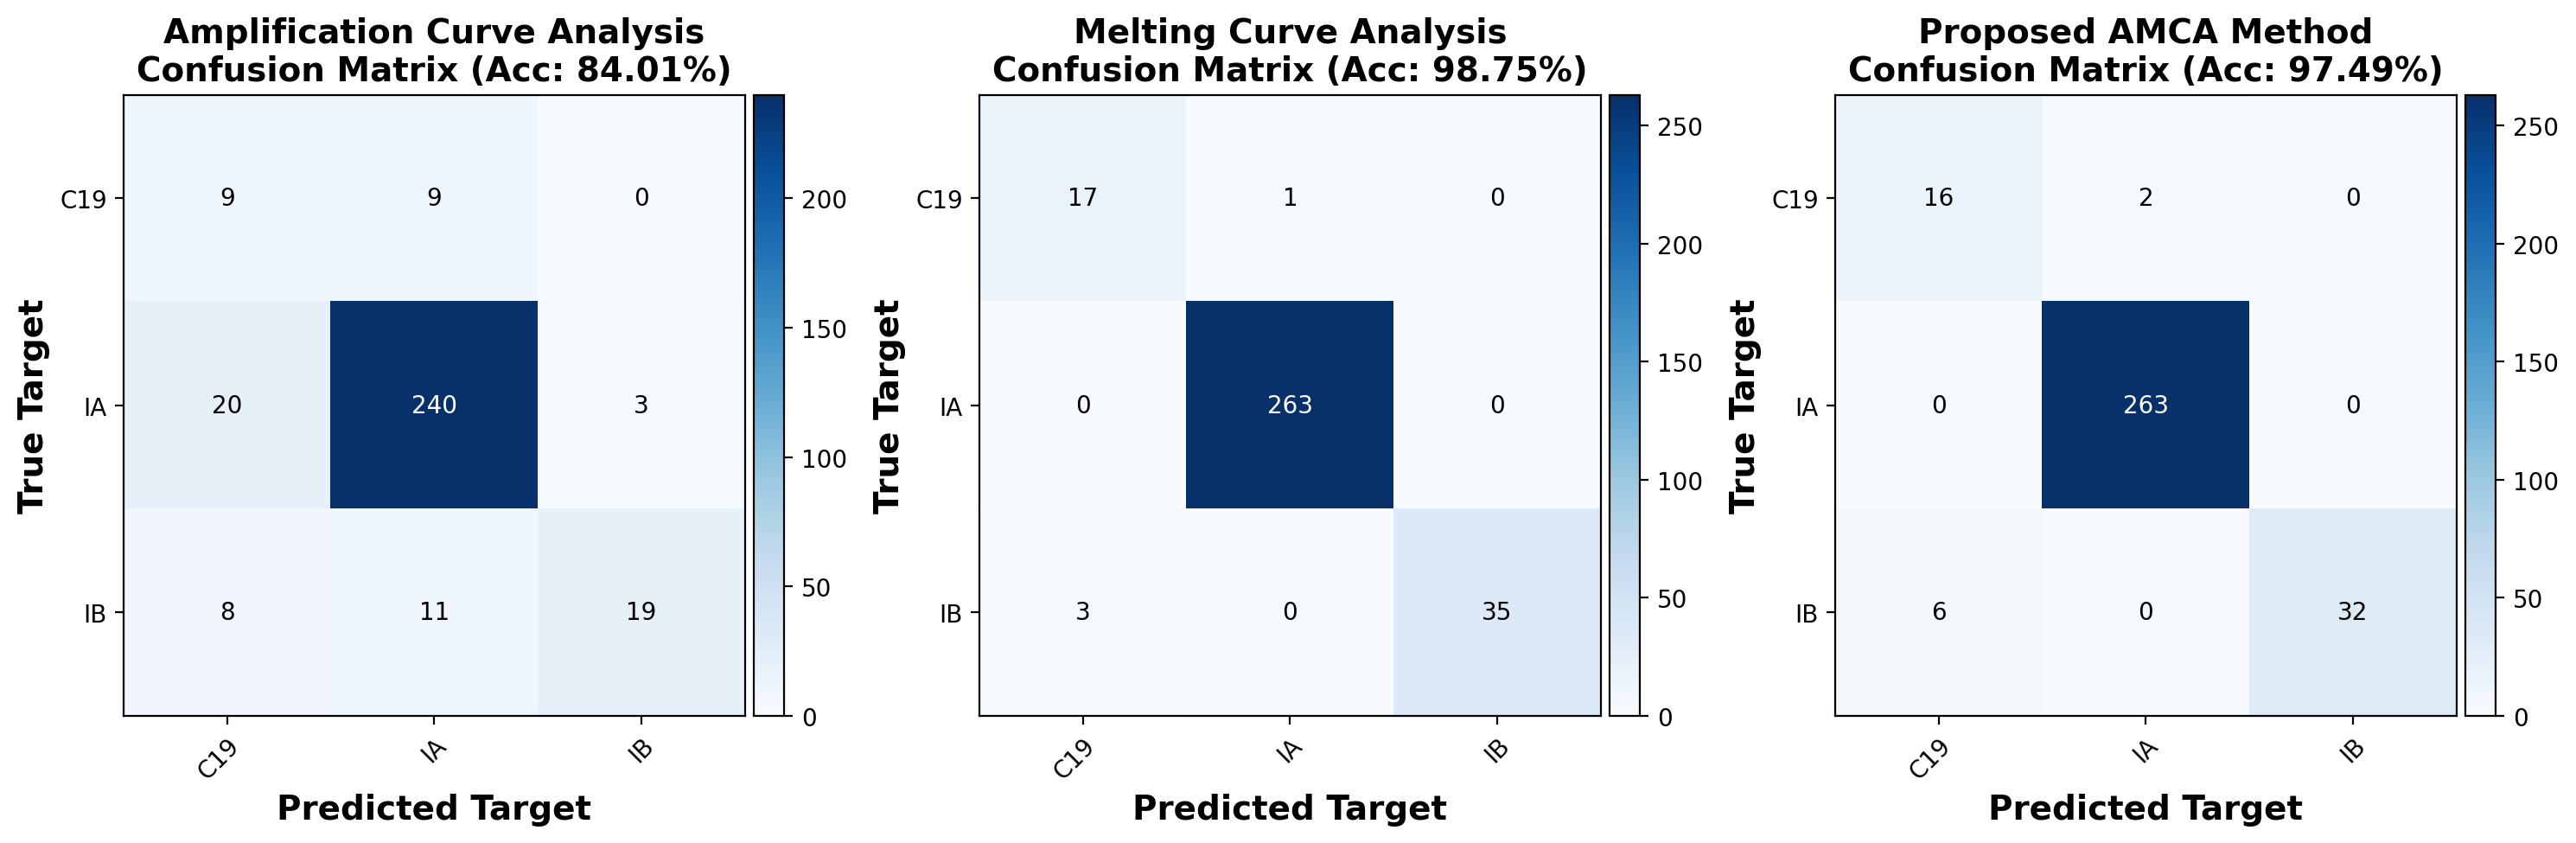

In [48]:
NN = False
FAKE_AC = False
NMETA = 6

X = df_chosen.iloc[:, NMETA+1:].values
X_MC = df_chosen.loc[:, ['MeltPeaks']].values

encoder = LabelEncoder()
y = encoder.fit_transform(df_chosen['Target'])

skf = StratifiedKFold(n_splits=5)

for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):

#####################################################################################################################################


    clf_AC, clf_AC_proba, _ = train_ACA_model(X[train_idx], y[train_idx], NN)
    clf_MC, clf_MC_proba = train_MCA_model(X_MC[train_idx], y[train_idx], NN)

    X_AC_MC_train = np.concatenate((clf_MC_proba, clf_AC_proba), axis=1)
    clf, clf_proba = train_AMCA_model(X_AC_MC_train, y[train_idx])
 
    X_AC_MC_test = np.concatenate((clf_MC.predict_proba(X_MC[test_idx]), 
                                    clf_AC.predict_proba(X[test_idx])), axis=1)

    y_preds = clf.predict(X_AC_MC_test)

    y_trues = y[test_idx].copy()

    y_preds_AC = clf_AC.predict(X[test_idx])

    y_preds_MC = clf_MC.predict(X_MC[test_idx])

    idx_confidence = np.ones(len(y_preds_AC), dtype=bool)

    print(X[train_idx].shape)
    print(X_MC[train_idx].shape)
    print(y[train_idx].shape)

    print(X[test_idx].shape)
    print(X_MC[test_idx].shape)
    print(y[test_idx].shape)
    
    
#####################################################################################################################################

    classes = encoder.classes_

    fig, ax = plt.subplots(1, 3, figsize=(15, 15), dpi=200)
    ax = ax.flatten()

    plotfunc.plot_confusion_matrix(y_trues[idx_confidence], y_preds_AC[idx_confidence], classes, ax[0], normalize=False)
    ax[0].set_title('Amplification Curve Analysis\n'+ax[0].get_title(), fontsize=14, weight='bold')
    ax[0].set_ylabel('True Target', fontsize=14, weight='bold')
    ax[0].set_xlabel('Predicted Target', fontsize=14, weight='bold')

    plotfunc.plot_confusion_matrix(y_trues[idx_confidence], y_preds_MC[idx_confidence], classes, ax[1], normalize=False)
    ax[1].set_title('Melting Curve Analysis\n'+ax[1].get_title(), fontsize=14, weight='bold')
    ax[1].set_ylabel('True Target', fontsize=14, weight='bold')
    ax[1].set_xlabel('Predicted Target', fontsize=14, weight='bold')

    plotfunc.plot_confusion_matrix(y_trues[idx_confidence], y_preds[idx_confidence], classes, ax[2], normalize=False)
    ax[2].set_title('Proposed AMCA Method\n'+ax[2].get_title(), fontsize=14, weight='bold')
    ax[2].set_ylabel('True Target', fontsize=14, weight='bold')
    ax[2].set_xlabel('Predicted Target', fontsize=14, weight='bold')

    plt.tight_layout()

plt.show()